<a href="https://colab.research.google.com/github/s07362022/CNN_to_train/blob/master/%E3%80%8C%E3%80%8Cnientzu_NN_ipynb%E3%80%8D%E7%9A%84%E5%89%AF%E6%9C%AC%E3%80%8D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import os
import matplotlib.pyplot as plt
drive.mount('/content/drive')
project_path='/content/drive/MyDrive/'
os.chdir(project_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
def shuffle(x,y):
    x = x.T
    y = y.T
    combine = np.c_[x.reshape(len(x), -1), y.reshape(len(y), -1)]
    np.random.shuffle(combine)
    return combine[:, :x.size//len(x)].reshape(x.shape).T,combine[:, x.size//len(x):].reshape(y.shape).T
class One_layer:    
    def __init__(self, in_dim, out_dim, act,lr,apt_type,val):
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.weight = np.random.randn(out_dim,in_dim+1)/10
        
        #self.weight = np.random.rand(out_dim,in_dim+1)/10
        
        act_list = {"relu":self.sigmoid, "tanh":self.tanh,"relu":self.relu,"sigmoid":self.sigmoid,
                    "softmax":self.softmax,"linear":self.linear}
        dif_list = {"relu":self.dif_sigmoid, "tanh":self.dif_tanh,"relu":self.dif_relu,"sigmoid":self.dif_sigmoid,
                    "softmax":self.dif_softmax,"linear":self.dif_linear}
        self.act = act_list[act]
        self.dif_act = dif_list[act]
        self.lr = lr
        self.apt_type=apt_type
        if apt_type=='Momentum':
          self.Momentum = val
          self.weight_f = np.random.randn(out_dim,in_dim+1)/10
        elif apt_type=='AdaGrad':
          self.EPS = val
          self.weight_f = np.zeros([out_dim,in_dim+1])
        #self.batch_size = batch_size
        self.input = np.array([]) #np.zeros((batch_size,in_dim))
        self.local_grad = np.array([]) #np.zeros((batch_size,out_dim))    
        self.value = np.array([])
        
    def forward(self,data):    
        data = np.concatenate((np.ones(data.shape[1]).reshape(1,-1),data), axis=0)         
        self.input = data
        self.value = self.weight.dot(data)
        return self.act(self.value) 
    
    def output(self,data): 
        data = np.concatenate((np.ones(data.shape[1]).reshape(1,-1),data), axis=0) 
        return self.act(self.weight.dot(data))    
    
    def backward(self,err):
        self.local_grad = self.dif_act(self.value,err)
        return self.weight.T.dot(self.local_grad)[1:,:]    
    
    def weight_renew(self,batch_size):       
        delta_w = self.lr*(self.local_grad).dot(self.input.T)#/batch_size#
        if self.apt_type=='None':
          self.weight = self.weight - delta_w
        elif self.apt_type=='Momentum':
          #self.weight = self.weight - delta_w + (self.Momentum * self.weight_f)
          self.weight = self.weight + self.weight_f
          #self.weight_f = (self.local_grad).dot(self.input.T)
          self.weight_f = self.Momentum * self.weight_f - delta_w
        elif self.apt_type=='AdaGrad':
          self.weight = self.weight - delta_w * (1/np.sqrt(self.weight_f+self.EPS))
          self.weight_f = self.weight_f + ((self.local_grad).dot(self.input.T))**2
        return self.weight    
    def sigmoid(self,z):
        return 1/(1+np.exp(-z))
    def tanh(self,z):
        return (np.exp(z)-np.exp(-z))/(np.exp(z)+np.exp(-z))
    def relu(self,z):
        return np.maximum(0,z)  
    
    def linear(self,z):
        return z 
    
    def dif_linear(self,z,err):
        return err
    
    def softmax(self,x):
        shiftx = x - np.max(x)
        exps = np.exp(shiftx)
        return exps / np.sum(exps,axis=0)    
    
    def dif_sigmoid(self,z,err):
        temp=self.sigmoid(z)        
        return (temp*(1-temp))*err    
    def dif_tanh(self,z,err):
        return (1-self.tanh(self,z)**2)*err    
    def dif_relu(self,z,err):
        return np.maximum(np.sign(z),0)*err     
    def dif_softmax(self,z,err):
        local_grad = []
        for i,ee in enumerate(z.T):
            ee = ee.T.reshape(1,-1)
            tt = self.softmax(ee.T)
            local_grad.append((np.eye(ee.size)*tt-tt.dot(tt.T)).dot(err[:,i]))
        return np.array(local_grad).T#(np.eye(self.out_dim)*S - S.dot(S.T)).dot(err)
    def fetch_w(self):
        return self.weight

class RBF_layer:    
    def __init__(self, in_dim, out_dim, cent_lr, wid_lr,data,act="gaussian"):
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.centers = self.plus_plus(data, out_dim)
        self.var_sqr_inv = np.ones((out_dim,in_dim))/10
        
        act_list = {"gaussian":self.gaussian, "inv_quadratic":self.quadratic}
        act_diff_list = {"gaussian":self.diff_gaussian, "inv_quadratic":self.diff_quadratic}
        
        self.act = act_list[act]
        self.act_diff = act_diff_list[act]
        
        self.cent_lr = cent_lr
        self.wid_lr = wid_lr
        self.output_norm1 = []
        self.out = []
        self.err_diff = []
    def gaussian(self,data):
        return np.exp(-data)
    def quadratic(self,data):
        return 1/(1+data)**0.5
    
    def forward(self,data): 
        o1 = []
        for i,cc in enumerate(self.centers):
            o1.append((data.T-cc))            
        self.output_norm1 = np.array(o1) 
        
        ot = []          
        for i,dc in enumerate(np.array(o1)):
            ot.append((dc**2).dot(self.var_sqr_inv[i].reshape(-1,1))[:,0])        
        temp =  self.act(np.array(ot))
        self.out = temp
        return temp    
    def output(self,data): 
        o1 = []
        for i,cc in enumerate(self.centers):
            o1.append((data.T-cc))             
        ot = []           
        for i,dc in enumerate(np.array(o1)):
            ot.append((dc**2).dot(self.var_sqr_inv[i].reshape(-1,1))[:,0])  
        temp =  self.act(np.array(ot))
        #self.out = temp
        return temp  
    
    def backward(self,err):
        self.err_diff = err
        return 0 
    
    def weight_renew(self,batch_size):   
        self.act_diff()
    
    def diff_quadratic(self):
        delta_c = []
        for i,dc in enumerate(self.output_norm1):
            delta_c.append(-(2*dc.T*self.var_sqr_inv[i].reshape(-1,1)).dot((self.err_diff[i]*-0.5*self.out[i]**3).reshape(-1,1))[:,0])
        delta_c = np.array(delta_c)
        
        delta_wid = []
        for i,dc in enumerate(self.output_norm1):
            delta_wid.append((self.err_diff[i]*-0.5*self.out[i]**3).dot(dc**2))
        delta_wid = np.array(delta_wid)
        
        self.centers -= self.cent_lr*delta_c
        self.var_sqr_inv = np.maximum(0,self.var_sqr_inv- self.wid_lr*delta_wid) 
        
    def diff_gaussian(self):
        delta_c = []
        for i,dc in enumerate(self.output_norm1):
            delta_c.append((2*dc.T*self.var_sqr_inv[i].reshape(-1,1)).dot((self.err_diff[i]*self.out[i]).reshape(-1,1))[:,0])
        delta_c = np.array(delta_c)
        
        delta_wid = []
        for i,dc in enumerate(self.output_norm1):
            delta_wid.append(-(self.err_diff[i]*self.out[i]).dot(dc**2))
        delta_wid = np.array(delta_wid)
        
        self.centers -= self.cent_lr*delta_c
        self.var_sqr_inv = np.maximum(0,self.var_sqr_inv- self.wid_lr*delta_wid) 
        
    def plus_plus(self,ds, k):
        centroids = [ds[0]]
        for _ in range(1, k):
            dist_sq = np.array([min([np.inner(c-x,c-x) for c in centroids]) for x in ds])
            probs = dist_sq/dist_sq.sum()
            cumulative_probs = probs.cumsum()
            r = np.random.rand()
            for j, p in enumerate(cumulative_probs):
                if r < p:
                    i = j
                    break
            centroids.append(ds[i])
        return np.array(centroids)

class NN_model:
    def __init__(self,layer_list,batch_size,loss):
        cost_list = {"Binary":self.CE_twoclass, "Multi_class":self.CE,
                     "Regression_mse":self.MSE,"Regression_mae":self.MAE}     
        cost_dif_list = {"Binary":self.dif_ce_twoclass, "Multi_class":self.dif_ce,
                         "Regression_mse":self.dif_mse,"Regression_mae":self.dif_mae}
        self.layer_list = layer_list
        self.batch_size = batch_size
        self.loss=cost_list[loss]
        self.dif_loss=cost_dif_list[loss]
        
        acc_type_list = {"Binary":self.acc_binary, "Multi_class":self.acc_multiclass
                         ,"Regression_mae":self.acc_regression,"Regression_mse":self.acc_regression}
        self.loss_func = acc_type_list[loss]
        
    def output(self,x):
        temp = x
        for ll in self.layer_list:
            temp = ll.output(temp)
        return temp
    
    def forward(self,x):
        temp = x
        for ll in self.layer_list:
            temp = ll.forward(temp)            
        return temp
    
    def back_propagation(self,x):
        temp = x
        for ll in self.layer_list[::-1]:
            temp = ll.backward(temp)
        return temp
    
    def loss_dif(self,y,y_hat):  
        return self.dif_loss(y,y_hat)    
    
    def MSE(self,y,y_hat,scale):
        err_avg = np.sum(((y_hat-y)*scale[1])**2,axis=0)
        return err_avg,sum(err_avg)/y_hat.shape[1]
    
    def MAE(self,y,y_hat,scale):
        err_avg = np.sum(np.abs((y_hat-y)*scale[1]),axis=0)
        return err_avg,sum(err_avg)/y_hat.shape[1]
    
    def CE_twoclass(self,p,y):
        err = -(y*np.log(p)+(1-y)*np.log(1-p))
        each_batch_avg_err = np.sum(err,axis=1)/err.shape[1]
        total_avg_err = sum(each_batch_avg_err)
        return err,total_avg_err
    
    def CE(self,p,y):
        err = -np.log(np.sum(p*y,axis=0))
        return err,sum(err)/p.shape[1]
    
    def dif_ce_twoclass(self,p,y):            
        #return (np.sum(-(np.divide(y, p) - np.divide(1 - y, 1 - p)),axis=1)/y.shape[1]).reshape(-1,1) 
        return (-(np.divide(y, p) - np.divide(1 - y, 1 - p)))
    
    def dif_ce(self,p,y):
        return -np.divide(1,p)*y 
    
    def dif_mae(self,y,y_hat):
        #return -(np.sum(y_hat-y,axis=1)/y.shape[1]).reshape(-1,1)
        return -np.sign((y_hat-y))
    
    def dif_mse(self,y,y_hat):
        #return -(np.sum(y_hat-y,axis=1)/y.shape[1]).reshape(-1,1)
        return -(y_hat-y)
    
    def update_weight(self):
        for ll in self.layer_list:
            ll.weight_renew(self.batch_size)
        return self.layer_list[len(self.layer_list)-1].weight
    def shuffle(self,x,y):
        x = x.T
        y = y.T
        combine = np.c_[x.reshape(len(x), -1), y.reshape(len(y), -1)]
        np.random.shuffle(combine)
        return combine[:, :x.size//len(x)].reshape(x.shape).T,combine[:, x.size//len(x):].reshape(y.shape).T
    
    # -------------------------------------- Acc --------------------------------------------------#
    def acc_binary(self,ee,epochs,x_train,x_valid,y_train,y_valid,scale=[]):
        y_va = self.output(x_valid)
        vl = self.loss(y_va,y_valid)[1]
        y_tr = self.output(x_train)
        tl = self.loss(y_tr,y_train)[1]        
        ta = self.bb_acc(y_tr,y_train)
        va = self.bb_acc(y_va,y_valid)        
        print("Epoch",ee,"/",epochs,"- loss: %.4f" %tl,
            "- accuracy: %.4f" %ta,
            "- val_loss: %.4f" %vl,
            "- val_accuracy: %.4f" %va)            
        return [tl,vl,ta,va]
    
        out =(yhat> 0.5).astype(int)
        return np.sum(np.equal(y.reshape(-1,1),out.reshape(-1,1)))/y.size
    
    def bb_acc(self,yhat,y):
        out =(yhat> 0.5).astype(int)
        return np.sum(np.equal(y.reshape(-1,1),out.reshape(-1,1)))/y.size
    
    def acc_multiclass(self,ee,epochs,x_train,x_valid,y_train,y_valid,scale=[]):
        y_va = self.output(x_valid)
        vl = self.loss(y_va,y_valid)[1]
        y_tr = self.output(x_train)
        tl = self.loss(y_tr,y_train)[1]         
        ta = self.mc_acc(y_tr,y_train)
        va = self.mc_acc(y_va,y_valid)        
        print("Epoch",ee,"/",epochs,"- loss: %.4f" %tl,
            "- accuracy: %.4f" %ta,
            "- val_loss: %.4f" %vl,
            "- val_accuracy: %.4f" %va)            
        return [tl,vl,ta,va]
    
    def mc_acc(self,yhat,y):
        y_hat = np.argmax(yhat,axis=0)
        yy = np.argmax(y,axis=0)
        return np.sum(np.equal(y_hat,yy))/len(yy)
    
    def acc_regression(self,ee,epochs,x_train,x_valid,y_train,y_valid,scale):
        y_va = self.output(x_valid)
        vl = self.loss(y_va,y_valid,scale)[1]
        y_tr = self.output(x_train)
        tl = self.loss(y_tr,y_train,scale)[1] 
        print("Epoch",ee,"/",epochs,"- loss: %.4f" %tl,
              "- val_loss: %.2f " %vl) 
        return [tl,vl]
    
    def training(self,x_train,x_valid,y_train,y_valid,epochs,scale=[]):        
        batches = int(x_train.shape[1]/self.batch_size)
        max_index = x_train.shape[1]    
        history = []
        w_list = []
        for ee in range(epochs):
            x_train,y_train = self.shuffle(x_train,y_train) ## 每次training data 的順序打亂
            for batch in range(batches):
                st = batch*self.batch_size
                end = min((st+self.batch_size),max_index)                  
                out = self.forward(x_train[:,st:end])
                err = self.loss_dif(out,y_train[:,st:end])
                self.back_propagation(err)
                w_list.append(self.update_weight())                
            history.append(self.loss_func(ee,epochs,x_train,x_valid,y_train,y_valid,scale))
        return np.array(history),w_list



In [3]:
import pandas as pd 
import numpy as np 
df = pd.read_csv("/content/drive/MyDrive/drug200.csv")

In [5]:
df

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY
...,...,...,...,...,...,...
195,56,F,LOW,HIGH,11.567,drugC
196,16,M,LOW,HIGH,12.006,drugC
197,52,M,NORMAL,HIGH,9.894,drugX
198,23,M,NORMAL,NORMAL,14.020,drugX


In [21]:
df.columns.values

array(['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K', 'Drug'], dtype=object)

In [4]:
df["Drug"].value_counts()

DrugY    91
drugX    54
drugA    23
drugC    16
drugB    16
Name: Drug, dtype: int64

In [4]:
df["Sex"] = df["Sex"].map({'F':0,'M':1}) 
df["BP"] = df["BP"].map({'LOW':0,'NORMAL':1,'HIGH':2})
df["Cholesterol"] = df["Cholesterol"].map({'HIGH':1,'NORMAL':0})
df["Drug"] = df["Drug"].map({'drugA':0,'drugB':1,'drugC':2,'drugX':3,'DrugY':4})

In [5]:
df

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,0,2,1,25.355,4
1,47,1,0,1,13.093,2
2,47,1,0,1,10.114,2
3,28,0,1,1,7.798,3
4,61,0,0,1,18.043,4
...,...,...,...,...,...,...
195,56,0,0,1,11.567,2
196,16,1,0,1,12.006,2
197,52,1,1,1,9.894,3
198,23,1,1,0,14.020,3


In [6]:
label = df['Drug'].values
dataset = df.drop(['Drug'],axis=1).values


In [7]:
label

array([4, 2, 2, 3, 4, 3, 4, 2, 4, 4, 2, 4, 4, 4, 3, 4, 3, 0, 2, 4, 4, 4,
       4, 4, 4, 4, 4, 3, 4, 4, 3, 1, 3, 4, 3, 3, 0, 3, 3, 3, 4, 1, 4, 3,
       3, 3, 0, 2, 4, 4, 4, 3, 4, 4, 1, 2, 1, 4, 3, 4, 4, 0, 4, 3, 1, 4,
       0, 3, 4, 4, 1, 4, 3, 4, 4, 4, 0, 4, 0, 3, 1, 3, 2, 0, 2, 1, 3, 4,
       4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 0, 0, 2, 3, 4, 3, 3, 4, 1, 4,
       0, 3, 3, 3, 3, 4, 3, 3, 0, 4, 4, 4, 4, 4, 1, 4, 4, 3, 4, 3, 4, 4,
       3, 4, 4, 3, 1, 0, 1, 3, 0, 4, 1, 4, 0, 3, 3, 0, 3, 2, 0, 1, 3, 3,
       4, 2, 0, 4, 2, 3, 3, 1, 3, 4, 4, 4, 4, 3, 4, 0, 3, 3, 4, 4, 0, 4,
       0, 4, 4, 4, 4, 3, 3, 4, 4, 4, 1, 0, 4, 4, 4, 0, 4, 2, 4, 2, 2, 3,
       3, 3])

In [9]:
dataset

array([[23.   ,  0.   ,  2.   ,  1.   , 25.355],
       [47.   ,  1.   ,  0.   ,  1.   , 13.093],
       [47.   ,  1.   ,  0.   ,  1.   , 10.114],
       [28.   ,  0.   ,  1.   ,  1.   ,  7.798],
       [61.   ,  0.   ,  0.   ,  1.   , 18.043],
       [22.   ,  0.   ,  1.   ,  1.   ,  8.607],
       [49.   ,  0.   ,  1.   ,  1.   , 16.275],
       [41.   ,  1.   ,  0.   ,  1.   , 11.037],
       [60.   ,  1.   ,  1.   ,  1.   , 15.171],
       [43.   ,  1.   ,  0.   ,  0.   , 19.368],
       [47.   ,  0.   ,  0.   ,  1.   , 11.767],
       [34.   ,  0.   ,  2.   ,  0.   , 19.199],
       [43.   ,  1.   ,  0.   ,  1.   , 15.376],
       [74.   ,  0.   ,  0.   ,  1.   , 20.942],
       [50.   ,  0.   ,  1.   ,  1.   , 12.703],
       [16.   ,  0.   ,  2.   ,  0.   , 15.516],
       [69.   ,  1.   ,  0.   ,  0.   , 11.455],
       [43.   ,  1.   ,  2.   ,  1.   , 13.972],
       [23.   ,  1.   ,  0.   ,  1.   ,  7.298],
       [32.   ,  0.   ,  2.   ,  0.   , 25.974],
       [57.   ,  1. 

In [10]:
len(dataset)*0.8

160.0

In [11]:
train_data = dataset[:160]
train_label = label[:160]
valid_data = dataset[161:]
valid_label = label[161:]

In [12]:
from keras.utils import np_utils
train_label = np_utils.to_categorical(train_label)
valid_label = np_utils.to_categorical(valid_label)

In [13]:
train_data=train_data.T
valid_data=valid_data.T
train_label=train_label.T
valid_label=valid_label.T
print(train_data.shape)
print(train_label.shape)
print(valid_data.shape)
print(valid_label.shape)

(5, 160)
(5, 160)
(5, 39)
(5, 39)


In [14]:
train_data.shape

(5, 160)

Epoch 0 / 100 - loss: 1.3175 - accuracy: 0.4437 - val_loss: 1.2701 - val_accuracy: 0.5128
Epoch 1 / 100 - loss: 1.2782 - accuracy: 0.4437 - val_loss: 1.2355 - val_accuracy: 0.5128
Epoch 2 / 100 - loss: 1.2383 - accuracy: 0.5437 - val_loss: 1.2045 - val_accuracy: 0.5128
Epoch 3 / 100 - loss: 1.2102 - accuracy: 0.5500 - val_loss: 1.1776 - val_accuracy: 0.5385
Epoch 4 / 100 - loss: 1.1870 - accuracy: 0.5687 - val_loss: 1.1594 - val_accuracy: 0.5385
Epoch 5 / 100 - loss: 1.1539 - accuracy: 0.5938 - val_loss: 1.1393 - val_accuracy: 0.5641
Epoch 6 / 100 - loss: 1.1387 - accuracy: 0.5938 - val_loss: 1.1348 - val_accuracy: 0.5641
Epoch 7 / 100 - loss: 1.1224 - accuracy: 0.6000 - val_loss: 1.1092 - val_accuracy: 0.5385
Epoch 8 / 100 - loss: 1.1061 - accuracy: 0.5938 - val_loss: 1.0987 - val_accuracy: 0.5641
Epoch 9 / 100 - loss: 1.0937 - accuracy: 0.5938 - val_loss: 1.0877 - val_accuracy: 0.5641
Epoch 10 / 100 - loss: 1.0833 - accuracy: 0.5938 - val_loss: 1.0797 - val_accuracy: 0.5641
Epoch 11 

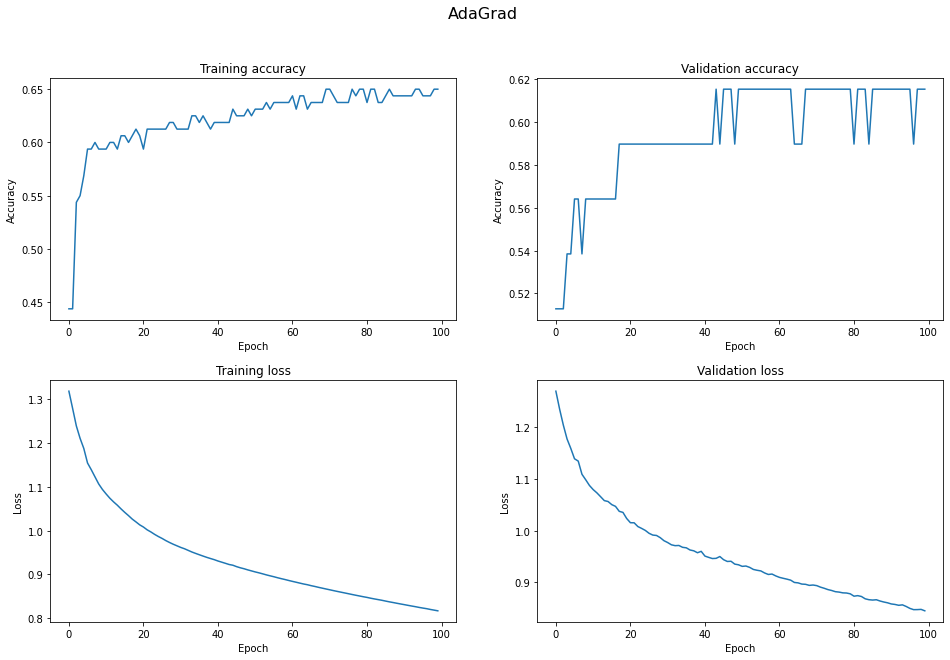

In [20]:
out_history=[]
all_w=[]
eta=0.01
model2 = NN_model([
            One_layer(in_dim=train_data.shape[0],out_dim=32,act="sigmoid",lr=eta,apt_type='AdaGrad',val=0.1),
            One_layer(in_dim=32,out_dim=5,act="softmax",lr=eta,apt_type='AdaGrad',val=0.1)],
            batch_size = 4,loss='Multi_class'
    ) 
history,all_w = model2.training(train_data,valid_data,train_label,valid_label,epochs=100)
out_history.append(history)

def draw(hh,title):
    fig = plt.figure(figsize=(16,10))
    fig.subplots_adjust(hspace=0.25, wspace=0.2)
    plt.subplot(2,2,1)
    for i,h in enumerate(hh):
        plt.plot(h.T[2])
    plt.title('Training accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')

    plt.subplot(2,2,2)
    for i,h in enumerate(hh):
        plt.plot(h.T[3])
    plt.title('Validation accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.subplot(2,2,3)
    for i,h in enumerate(hh):
        plt.plot(h.T[0])
    plt.title('Training loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')

    plt.subplot(2,2,4)
    for i,h in enumerate(hh):
        plt.plot(h.T[1])
    plt.title('Validation loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')

    fig.suptitle(title, fontsize=16)
    plt.show()
draw(out_history,"AdaGrad")

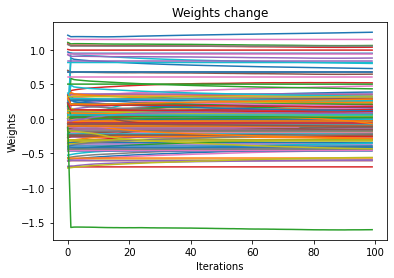

In [16]:
plt.title('Weights change')
plt.ylabel('Weights')
plt.xlabel('Iterations')
plt.plot(np.array(all_w).reshape((len(all_w),all_w[0].shape[0]*all_w[0].shape[1])))
plt.show()

Epoch 0 / 32 - loss: 1.5688 - accuracy: 0.2500 - val_loss: 1.5663 - val_accuracy: 0.2308
Epoch 1 / 32 - loss: 1.5660 - accuracy: 0.2500 - val_loss: 1.5636 - val_accuracy: 0.2308
Epoch 2 / 32 - loss: 1.5637 - accuracy: 0.2562 - val_loss: 1.5616 - val_accuracy: 0.2308
Epoch 3 / 32 - loss: 1.5619 - accuracy: 0.2625 - val_loss: 1.5599 - val_accuracy: 0.2308
Epoch 4 / 32 - loss: 1.5602 - accuracy: 0.2625 - val_loss: 1.5584 - val_accuracy: 0.2308
Epoch 5 / 32 - loss: 1.5586 - accuracy: 0.2625 - val_loss: 1.5570 - val_accuracy: 0.2308
Epoch 6 / 32 - loss: 1.5572 - accuracy: 0.2625 - val_loss: 1.5558 - val_accuracy: 0.2308
Epoch 7 / 32 - loss: 1.5559 - accuracy: 0.2625 - val_loss: 1.5546 - val_accuracy: 0.2308
Epoch 8 / 32 - loss: 1.5546 - accuracy: 0.2687 - val_loss: 1.5534 - val_accuracy: 0.2308
Epoch 9 / 32 - loss: 1.5534 - accuracy: 0.2687 - val_loss: 1.5523 - val_accuracy: 0.2308
Epoch 10 / 32 - loss: 1.5523 - accuracy: 0.2750 - val_loss: 1.5513 - val_accuracy: 0.2308
Epoch 11 / 32 - loss

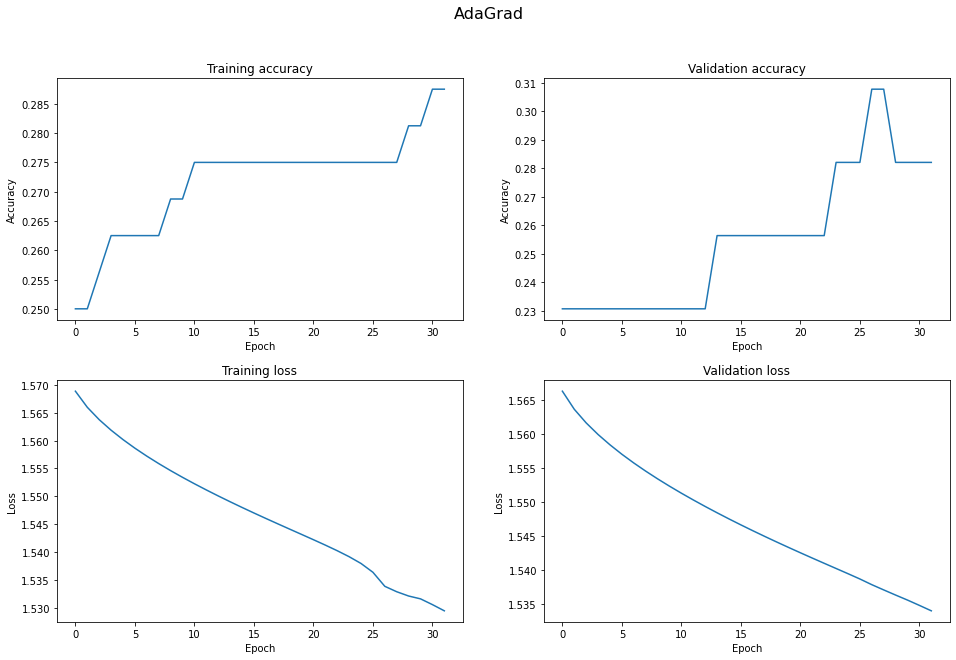

In [18]:
out_history=[]
all_w=[]
eta=0.001
model3 = NN_model([
            RBF_layer(in_dim=train_data.shape[0], out_dim=32 , cent_lr = eta, wid_lr=eta,data =train_data.T,act= "gaussian"),
            One_layer(in_dim=32,out_dim=5,act="softmax",lr=eta,apt_type='AdaGrad',val=0.1)],
            batch_size = 4,loss='Multi_class'
    ) 
history,all_w = model3.training(train_data,valid_data,train_label,valid_label,epochs=32)
out_history.append(history)

def draw(hh,title):
    fig = plt.figure(figsize=(16,10))
    fig.subplots_adjust(hspace=0.25, wspace=0.2)
    plt.subplot(2,2,1)
    for i,h in enumerate(hh):
        plt.plot(h.T[2])
    plt.title('Training accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')

    plt.subplot(2,2,2)
    for i,h in enumerate(hh):
        plt.plot(h.T[3])
    plt.title('Validation accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.subplot(2,2,3)
    for i,h in enumerate(hh):
        plt.plot(h.T[0])
    plt.title('Training loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')

    plt.subplot(2,2,4)
    for i,h in enumerate(hh):
        plt.plot(h.T[1])
    plt.title('Validation loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')

    fig.suptitle(title, fontsize=16)
    plt.show()
draw(out_history,"AdaGrad")

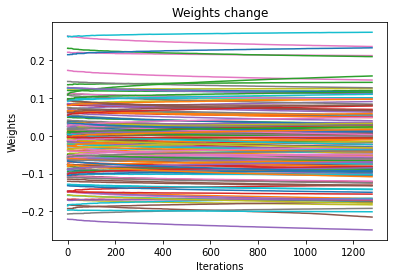

In [19]:
plt.title('Weights change')
plt.ylabel('Weights')
plt.xlabel('Iterations')
plt.plot(np.array(all_w).reshape((len(all_w),all_w[0].shape[0]*all_w[0].shape[1])))
plt.show()